In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm
import random
import seaborn as sns
# sns.set()

In [58]:
from common import get_freq_data, signal_cyclic_shift, get_ref_time, generate_multi_signal

In [59]:
def get_data(is_one_signal=False):
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])
    
    ## Let's shift each signal so that reference time matches for each signal
    if not is_one_signal:
        y = y.astype(int)
        mean_ref_time = int(y.mean())
        X = np.array([signal_cyclic_shift(signal, mean_ref_time - y[i]) for i, signal in enumerate(X, 0)])
        y = np.array([mean_ref_time]*len(X))
    return X, y

In [60]:
X_two_signals, y_two_signals = get_data(is_one_signal=False)

X_two_signals_train, X_two_signals_test, y_two_signals_train, y_two_signals_test = train_test_split(X_two_signals,\
                                                                                    y_two_signals, test_size=0.2, shuffle=False)

In [61]:
X_one_signal, y_one_signal = get_data(is_one_signal=True)

X_one_signal_train, X_one_signal_test, y_one_signal_train, y_one_signal_test = train_test_split(X_one_signal,\
                                                                                    y_one_signal, test_size=0.2, shuffle=False)

(array([  60.,  372.,  985., 1183., 1040., 1182., 1042., 1053.,  730.,
         201.]),
 array([354., 360., 366., 372., 378., 384., 390., 396., 402., 408., 414.]),
 <a list of 10 Patch objects>)

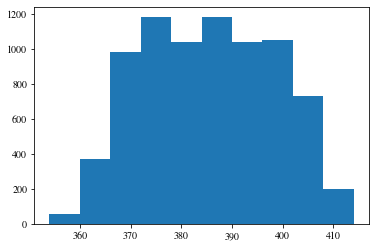

In [62]:
ARGMIN_DISTR = np.argmin(X_one_signal, axis=1)
plt.hist(ARGMIN_DISTR)

In [63]:
from sklearn.utils import shuffle

def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha, argmin_distr=ARGMIN_DISTR)
        
        
        X.append(signal['multi_impulse'])
        y.append(signal['multi_ref_time']) 
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [64]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


tau_train_range = list(map(int, get_truncated_normal(mean=0, sd=5, low=-20, upp=20).rvs(1000)))
tau_test_range = list(map(int, get_truncated_normal(mean=0, sd=5, low=-20, upp=20).rvs(1000)))
alpha_train_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 0.05, 0.05)])
alpha_test_range = np.array([0, 0.01, 0.05, 0.1, 0.5])
freq_values = [1, 5, 10, 25, 50, 100]

In [65]:
import xgboost as xgb
from sklearn.model_selection import cross_validate
from math import sqrt

In [66]:
[np.round(alpha, decimals=3) for alpha in alpha_train_range[::10]]

[0.001, 0.003, 0.01, 0.032, 0.1, 0.316, 1.0]

In [67]:
LABEL_FONTSIZE=14

In [68]:
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

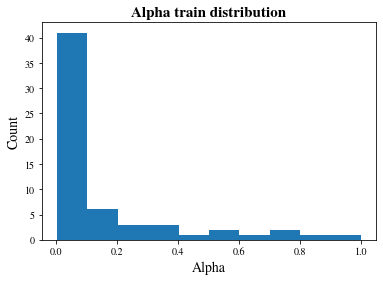

In [69]:
plt.title("Alpha train distribution",  weight='bold', fontsize=15)
plt.hist(alpha_train_range)
plt.xlabel("Alpha", fontsize=LABEL_FONTSIZE)
plt.ylabel("Count", fontsize=LABEL_FONTSIZE)
plt.show()

Text(0, 0.5, 'Count')

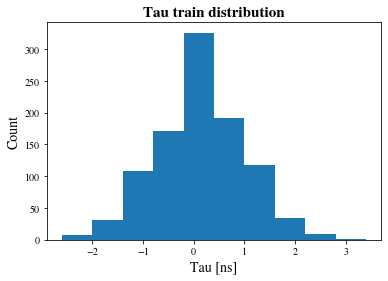

In [70]:
TIME_SCALE_COEF = 0.2
plt.title("Tau train distribution", weight='bold', fontsize=15)
plt.hist(np.array(tau_train_range)*TIME_SCALE_COEF)
plt.xlabel("Tau [ns]", fontsize=LABEL_FONTSIZE)
plt.ylabel("Count", fontsize=LABEL_FONTSIZE)

In [71]:
from sklearn.metrics import mean_squared_error

In [72]:
from shuffle_voter import ShuffleVoter

In [73]:
import pickle

MODEL_LOAD_PATH = './models/classifier/'

def load_model(path):
    with open(path, 'rb') as fid:
        model = pickle.load(fid)
        return model

In [74]:
reg_multiple = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)

reg_single = xgb.XGBRegressor(objective="reg:linear", alpha= 0.00244, booster='dart', eta= 0.017326, gamma=0.19504, 
                           reg_lambda=0.22451, max_depth=8, verbosity=0)

In [75]:
clf_model = load_model(MODEL_LOAD_PATH + 'ensemble_freq_' + str(1) + '.pkl')

In [76]:
X_train, y_train = prepare_data(X_two_signals_train, y_two_signals_train, tau_train_range, alpha_train_range, data_size=2000)
y_pred = clf_model.predict(X_train)

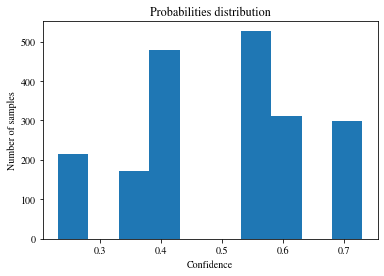

In [77]:
plt.hist(y_pred)
plt.xlabel("Confidence")
plt.ylabel("Number of samples")
plt.title("Probabilities distribution")
plt.show()

In [78]:
two_signals_scores = {alpha:[] for alpha in alpha_test_range}

TEST_SIZE = len(X_two_signals_test)
TIME_SCALE_COEF = 0.2
X_train, y_train = prepare_data(X_two_signals_train, y_two_signals_train, tau_train_range, alpha_train_range, data_size=len(X_two_signals))


for freq in freq_values:
    X_train_freq = get_freq_data(X_train, freq=freq)
    reg_multiple.fit(X_train_freq, y_train)
    
    for alpha in tqdm.tqdm(alpha_test_range):
        X_test_cur, y_test_cur = prepare_data(X_two_signals_test, y_two_signals_test, tau_test_range, [alpha], data_size=TEST_SIZE)
        X_test_freq = get_freq_data(X_test_cur, freq=freq)
        y_pred = reg_multiple.predict(X_test_freq)
        two_signals_scores[alpha].append(sqrt(mean_squared_error(y_pred, y_test_cur)) * TIME_SCALE_COEF)




  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:04<00:16,  4.23s/it]


 40%|████      | 2/5 [00:06<00:11,  3.74s/it]


 60%|██████    | 3/5 [00:11<00:08,  4.02s/it]


 80%|████████  | 4/5 [00:14<00:03,  3.61s/it]


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]



  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:02<00:11,  2.95s/it]


 40%|████      | 2/5 [00:05<00:08,  2.87s/it]


 60%|██████    | 3/5 [00:09<00:06,  3.07s/it]


 80%|████████  | 4/5 [00:13<00:03,  3.42s/it]


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]



  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:02<00:11,  2.97s/it]


 40%|████      | 2/5 [00:05<00:08,  2.87s/it]


 60%|██████    | 3/5 [00:08<00:05,  2.80s/it]


 80%|████████  | 4/5 [00:11<00:03,  3.05s/it]


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]



  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:03<00:12,  3.14s/it]


 40%|████      | 2/5 [00:06<00:09,  3.15s/it]


 60%|██████    | 3

In [ ]:
cascade_scores = {alpha:[] for alpha in alpha_test_range}


TEST_SIZE = len(X_two_signals_test)
TIME_SCALE_COEF = 0.2
CLF_THRESHOLD = 0.3

X_train, y_train = prepare_data(X_two_signals_train, y_two_signals_train, tau_train_range, alpha_train_range, data_size=len(X_two_signals))

for freq in freq_values:
    clf_model = load_model(MODEL_LOAD_PATH + 'ensemble_freq_' + str(freq) + '.pkl')
    X_train_freq = get_freq_data(X_train, freq=freq)
    reg_multiple.fit(X_train_freq, y_train)
    
    X_train_freq = get_freq_data(X_one_signal_train, freq=freq)
    reg_single.fit(X_train_freq, y_one_signal_train)
        
    for alpha in tqdm.tqdm(alpha_test_range):
        X_test_cur, y_test_cur = prepare_data(X_two_signals_test, y_two_signals_test, tau_test_range, [alpha], data_size=TEST_SIZE)
        X_test_freq = get_freq_data(X_test_cur, freq=freq)
        
        is_single_pred = np.round(clf_model.predict(X_test_freq) - CLF_THRESHOLD + 0.5).astype(bool)
        is_multiple_pred = np.logical_not(is_single_pred)

        X_test_cur_single = X_test_freq[is_single_pred]
        y_test_cur_single = y_test_cur[is_single_pred]
        X_test_cur_multiple = X_test_freq[is_multiple_pred]
        y_test_cur_multiple = y_test_cur[is_multiple_pred]
        
        y_pred_single = reg_single.predict(X_test_cur_single)
        y_pred_multiple = reg_multiple.predict(X_test_cur_multiple)
        y_pred = np.concatenate([y_pred_single, y_pred_multiple])
        y_test_cur = np.concatenate([y_test_cur_single, y_test_cur_multiple])
       
        cascade_scores[alpha].append(sqrt(mean_squared_error(y_pred, y_test_cur)) * TIME_SCALE_COEF)

In [ ]:
# thresholds = [0.3, 0.35, 0.4, 0.5, 0.6, 0.7]
# threshold_scores = {threshold:{alpha:[] for alpha in alpha_test_range} for threshold in thresholds}


# TEST_SIZE = len(X_two_signals_test)
# TIME_SCALE_COEF = 0.2
# CLF_THRESHOLD = 0.3

# # X_train, y_train = prepare_data(X_two_signals_train, y_two_signals_train, tau_train_range, alpha_train_range, data_size=len(X_two_signals))


# for freq in freq_values:
#     clf_model = load_model(MODEL_LOAD_PATH + 'ensemble_freq_' + str(freq) + '.pkl')
#     X_train_freq = get_freq_data(X_train, freq=freq)
#     reg_multiple.fit(X_train_freq, y_train)
    
#     X_train_freq = get_freq_data(X_one_signal_train, freq=freq)
#     reg_single.fit(X_train_freq, y_one_signal_train)
        
#     print()
#     print()
#     print("-----------------------------")
#     print("freq:", freq)
#     for threshold in tqdm.tqdm(thresholds):
#         for alpha in alpha_test_range:
#             X_test_cur, y_test_cur = prepare_data(X_two_signals_test, y_two_signals_test, tau_test_range, [alpha], data_size=TEST_SIZE)
#             X_test_freq = get_freq_data(X_test_cur, freq=freq)

#             is_single_pred = np.round(clf_model.predict(X_test_freq) - threshold + 0.5).astype(bool)
#             is_multiple_pred = np.logical_not(is_single_pred)

#             X_test_cur_single = X_test_freq[is_single_pred]
#             y_test_cur_single = y_test_cur[is_single_pred]
#             X_test_cur_multiple = X_test_freq[is_multiple_pred]
#             y_test_cur_multiple = y_test_cur[is_multiple_pred]

#             y_pred_single = reg_single.predict(X_test_cur_single)
#             y_pred_multiple = reg_multiple.predict(X_test_cur_multiple)
#             y_pred = np.concatenate([y_pred_single, y_pred_multiple])
#             y_test_cur = np.concatenate([y_test_cur_single, y_test_cur_multiple])

#             threshold_scores[threshold][alpha].append(sqrt(mean_squared_error(y_pred, y_test_cur)) * TIME_SCALE_COEF)

In [ ]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(threshold_scores, 'threshold_scores_models_comparison')

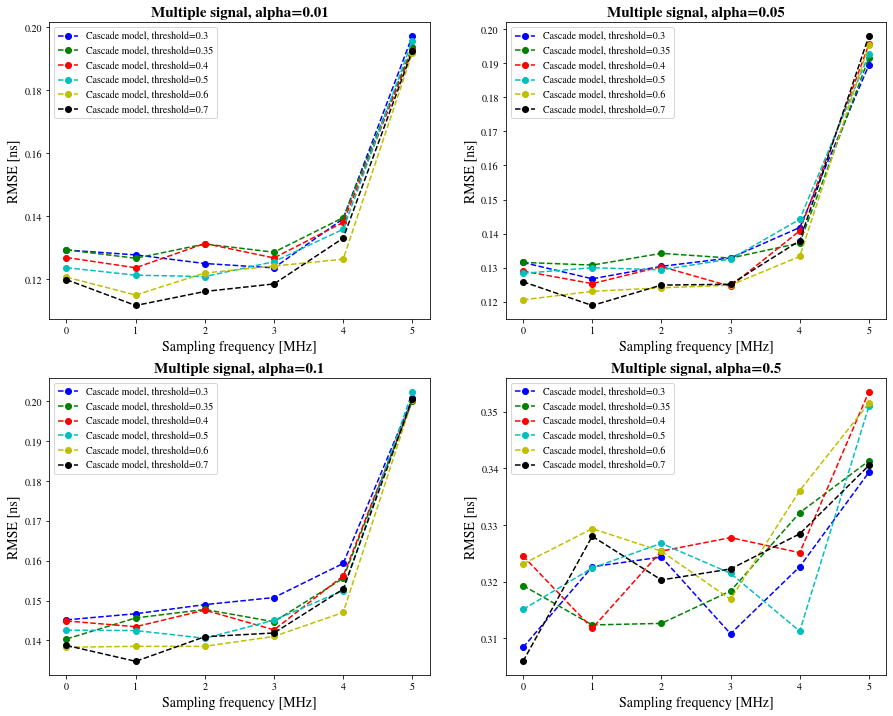

In [27]:
colors = ['b', 'g', 'r', 'c', 'y', 'k']

ORIGIN_FREQ = 5000

f, ax = plt.subplots(2, 2, figsize=(15, 12))

for num, alpha in enumerate(alpha_test_range[1:5], 0):
    idx1, idx2 = num//2, num%2
    
    for i, t in enumerate(thresholds, 0):
        ax[idx1][idx2].plot(threshold_scores[t][alpha], marker='o', linestyle='--', color=colors[i])

    ax[idx1][idx2].set_title("Multiple signal, alpha=" + str(alpha), weight='bold', fontsize=15)
    ax[idx1][idx2].set_ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
    ax[idx1][idx2].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    ax[idx1][idx2].set_xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
    ax[idx1][idx2].legend(["Cascade model, threshold=" + str(t) for t in thresholds])
plt.show()

In [ ]:
alpha_one_signal_test = [0, 0.01, 0.05, 0.1, 0.5] 
one_signal_scores = {alpha: [] for alpha in alpha_one_signal_test} 
one_signal_scores[-1] = [] ### -1 - predict for one signal data

In [ ]:
for freq in tqdm.tqdm(freq_values):
    X_train_freq = get_freq_data(X_one_signal_train, freq=freq)
    reg_single.fit(X_train_freq, y_one_signal_train)
    X_test_freq = get_freq_data(X_one_signal_test, freq=freq)
    y_pred = reg_single.predict(X_test_freq)
    one_signal_scores[-1].append(sqrt(mean_squared_error(y_pred, y_one_signal_test)) * TIME_SCALE_COEF)

In [ ]:
for freq in freq_values:
    X_train_freq = get_freq_data(X_one_signal_train, freq=freq)
    reg_single.fit(X_train_freq, y_one_signal_train)
    
    for alpha in tqdm.tqdm(alpha_one_signal_test):
        X_test_cur, y_test_cur = prepare_data(X_two_signals_test, y_two_signals_test, tau_test_range, [alpha], data_size=TEST_SIZE)
        X_test_freq = get_freq_data(X_test_cur, freq=freq)
        y_pred = reg_single.predict(X_test_freq)
        one_signal_scores[alpha].append(sqrt(mean_squared_error(y_pred, y_test_cur)) * TIME_SCALE_COEF)

In [56]:
colors = ['b', 'g']

ORIGIN_FREQ = 5000

# plt.plot(one_signal_scores[-1], marker='o', linestyle='--', color=colors[0])

for i, alpha in enumerate(alpha_one_signal_test[:2], 1):
    plt.plot(one_signal_scores[alpha], marker='o', linestyle='--', color=colors[i])
for i, alpha in enumerate(alpha_one_signal_test[:2], 0):
    plt.plot(two_signals_scores[alpha], marker='o', color=colors[i])

plt.title("Models comparison for multiple signal", weight='bold', fontsize=15)
plt.ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
plt.xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["One signal model, alpha=" + str(a) for a in alpha_one_signal_test[:2]] +\
                      ["Two signals model, alpha=" + str(a) for a in alpha_one_signal_test[:2]])
plt.show()

NameError: name 'alpha_one_signal_test' is not defined

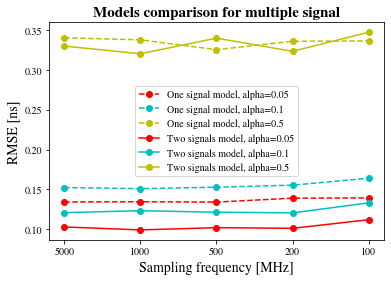

In [32]:
colors = ['r', 'c', 'y']


ORIGIN_FREQ = 5000

for i, alpha in enumerate(alpha_one_signal_test[2:], 0):
    plt.plot(one_signal_scores[alpha], marker='o', linestyle='--', color=colors[i])
for i, alpha in enumerate(alpha_one_signal_test[2:], 0):
    plt.plot(two_signals_scores[alpha], marker='o', color=colors[i])

plt.title("Models comparison for multiple signal", weight='bold', fontsize=15)
plt.ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
plt.xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["One signal model, alpha=" + str(a) for a in alpha_one_signal_test[2:]] +\
                      ["Two signals model, alpha=" + str(a) for a in alpha_one_signal_test[2:]], loc='center')
plt.show()

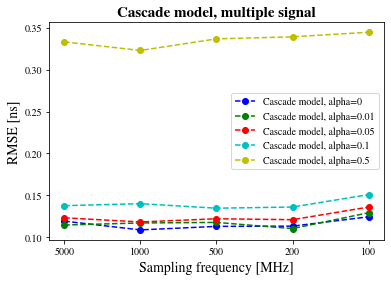

In [50]:
colors = ['b', 'g', 'r', 'c', 'y']

ORIGIN_FREQ = 5000

# plt.plot(one_signal_scores[-1], marker='o', linestyle='--', color=colors[0])

for i, alpha in enumerate(alpha_one_signal_test, 0):
    plt.plot(cascade_scores[alpha], marker='o', linestyle='--', color=colors[i])

plt.title("Cascade model, multiple signal", weight='bold', fontsize=15)
plt.ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
plt.xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["Cascade model, alpha=" + str(a) for a in alpha_one_signal_test])
plt.show()

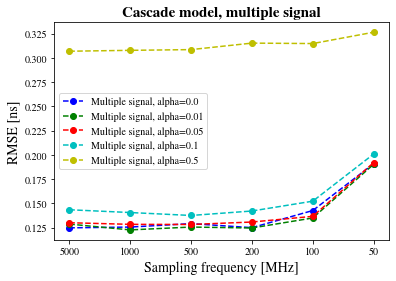

In [51]:
colors = ['b', 'g', 'r', 'c', 'y']

ORIGIN_FREQ = 5000

# plt.plot(one_signal_scores[-1], marker='o', linestyle='--', color=colors[0])

for i, alpha in enumerate(alpha_test_range, 0):
    plt.plot(cascade_scores[alpha], marker='o', linestyle='--', color=colors[i])

plt.title("Cascade model, multiple signal", weight='bold', fontsize=15)
plt.ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
plt.xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["Multiple signal, alpha=" + str(a) for a in alpha_test_range])
plt.show()

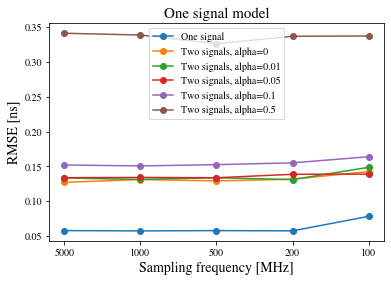

In [33]:
ORIGIN_FREQ = 5000


plt.title("One signal model", fontsize=15)
for alpha in [-1] + alpha_one_signal_test:
    plt.plot(one_signal_scores[alpha], marker='o')
plt.ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
plt.xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["One signal"] + ["Two signals, alpha=" + str(a) for a in alpha_one_signal_test])
plt.show()

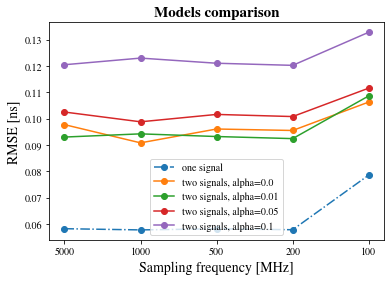

In [34]:
plt.plot(one_signal_scores[-1], marker='o', linestyle='-.')

for alpha in list(two_signals_scores.keys())[:4]:
    plt.plot(two_signals_scores[alpha], marker='o', linestyle='-')

plt.title("Models comparison", fontsize=15, weight='bold')
plt.ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
plt.xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(['one signal'] + ['two signals, alpha=' + str(key) for key in two_signals_scores.keys()])
plt.show()

### -----------------------------------------------

In [ ]:
X_two_signals, y_two_signals = get_data(is_one_signal=False)
mean_argmin =  int(np.argmin(X_two_signals, axis=1).mean())

X_two_signals_train, X_two_signals_test, y_two_signals_train, y_two_signals_test = train_test_split(X_two_signals,\
                                                                                    y_two_signals, test_size=0.2, shuffle=False)

In [ ]:
X_one_signal, y_one_signal = get_data(is_one_signal=True)

In [ ]:
X_one_signal_train, X_one_signal_test, y_one_signal_train, y_one_signal_test = train_test_split(X_one_signal,\
                                                                                    y_one_signal, test_size=0.2, shuffle=False)

In [ ]:
X_one_signal_test.shape

In [ ]:
X_two_signals_test.shape

In [ ]:
for i in range(len(X_two_signals_test)):
    cur_argmin = np.argmin(X_two_signals_test[i])
    X_two_signals_test[i] = signal_cyclic_shift(X_two_signals_test[i], mean_argmin - cur_argmin)
    y_two_signals_test[i] += mean_argmin - cur_argmin

In [ ]:
plt.hist(y_one_signal_test)

In [ ]:
plt.hist(y_two_signals_test)

In [ ]:
X_two_signals_test[0]

In [ ]:
X_one_signal_test[0]

### --------------------------------------------

In [ ]:
FONTSIZE=15

In [ ]:
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

In [ ]:
plt.title("One signal", weight='bold', fontsize=FONTSIZE)
plt.plot(X_one_signal[0])
plt.show()

In [ ]:
tau = 40
alpha = 0.5
multiple_signal = generate_multi_signal(X_two_signals, y_two_signals, tau, alpha)['multi_impulse']
plt.title("Multiple signal, tau = %d, alpha = %0.1f" %(tau, alpha), weight='bold', fontsize=FONTSIZE)
plt.plot(multiple_signal)
plt.show()

In [ ]:
plt.title("Mu")